In [1]:
import sys
sys.path.append("c:/users/david/desktop/sandbox")
import pandas as pd
import numpy as np
from pyrecs.train import lightfm_wrapper

%load_ext autoreload
%autoreload 2

C:\Users\David\Desktop\Sandbox\pyrecs\env\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


# Pure CF

In [2]:
ratings = pd.read_csv('../data/movielens-1m/ratings.dat', delimiter='::', 
                      names=['user_id', 'movie_id', 'rating', 'timestamp'], 
                      engine='python')
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['user_id'] = ratings['user_id'].astype(str)
ratings['movie_id'] = ratings['movie_id'].astype(str)

print(ratings['timestamp'].describe(datetime_is_numeric=True))
print(ratings.shape)
ratings.head()

count                          1000209
mean     2000-10-22 19:41:35.404665856
min                2000-04-25 23:05:32
25%                2000-08-03 11:37:17
50%                2000-10-31 18:46:46
75%                2000-11-26 06:42:19
max                2003-02-28 17:49:50
Name: timestamp, dtype: object
(1000209, 4)


,user_id,movie_id,rating,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [48]:
train_df = ratings[ratings['timestamp'] < '2002'].copy()
test_df = ratings[ratings['timestamp'] >= '2002'].copy()

train_df.shape, test_df.shape

((972815, 4), (27394, 4))

In [49]:
train_df['user_id'].nunique(), test_df['user_id'].nunique(), len(set(train_df['user_id'].unique()) & set(test_df['user_id'].unique()))

(6038, 587, 585)

In [50]:
train_df['movie_id'].nunique(), test_df['movie_id'].nunique(), len(set(train_df['movie_id'].unique()) & set(test_df['movie_id'].unique()))

(3695, 3030, 3019)

In [51]:
# TODO: Cast all id columns to strings, or ensure they're strings in checks
# TODO: Be able to use interaction ratings as weights (interaction type)
# TODO: Plot cold-start test MAP@K separately than warm-start, and then plot them together

In [44]:
model_kwargs = {
    'no_components':32,
    'learning_rate':0.05,
    'loss':'warp',
    'random_state':42
}
train_kwargs = {
    'num_epochs':2,
    'num_threads':1,
    'eval_epochs':'all',
    'plot':True
}
lfm = lightfm_wrapper.LightFM(users_col='user_id', items_col='movie_id', interactions_type='ones',
                              model_kwargs=model_kwargs, train_kwargs=train_kwargs,
                              n_recs=10, tfrs_prediction_batch_size=128)

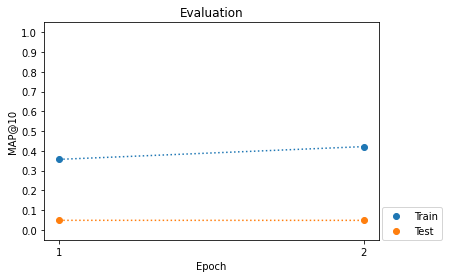

Training: 100%|██████████████████████████████████████████████████████████████████████████| 2/2 [02:28<00:00, 74.44s/it]


In [45]:
lfm.run(train_df=train_df, test_df=test_df)

In [46]:
lfm.train_evaluations, lfm.test_evaluations

([0.3569750114355117, 0.4214423042658109],
 [0.04851893257962989, 0.04829169101660195])

# Hybrid CF

In [ ]:
users = pd.read_csv('../data/movielens-1m/users.dat', delimiter='::',
                      header=None, names=['user_id', 'gender', 'age', 'occupation', 'zip'], 
                    engine='python')
print(users.shape)
display(users.head())


movies = pd.read_csv('../data/movielens-1m/movies.dat', delimiter='::',
                       header=None, names=['movie_id', 'title', 'genres'], 
                     engine='python')
print(movies.shape)
display(movies.head())